<a href="https://colab.research.google.com/github/protozeit/music-genre-classification/blob/master/exploration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
! curl -O https://os.unil.cloud.switch.ch/fma/fma_metadata.zip && unzip fma_metadata.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  341M  100  341M    0     0  17.1M      0  0:00:19  0:00:19 --:--:-- 26.0M
Archive:  fma_metadata.zip
 bunzipping: fma_metadata/README.txt  
 bunzipping: fma_metadata/checksums  
 bunzipping: fma_metadata/not_found.pickle  
 bunzipping: fma_metadata/raw_genres.csv  
 bunzipping: fma_metadata/raw_albums.csv  
 bunzipping: fma_metadata/raw_artists.csv  
 bunzipping: fma_metadata/raw_tracks.csv  
 bunzipping: fma_metadata/tracks.csv  
 bunzipping: fma_metadata/genres.csv  
 bunzipping: fma_metadata/raw_echonest.csv  
 bunzipping: fma_metadata/echonest.csv  
 bunzipping: fma_metadata/features.csv  


In [3]:
! curl -O https://raw.githubusercontent.com/protozeit/music-genre-classification/master/utils.py

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 11659  100 11659    0     0  70234      0 --:--:-- --:--:-- --:--:-- 70234


In [390]:
%matplotlib inline

import os

import IPython.display as ipd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn as skl
import sklearn.utils, sklearn.preprocessing, sklearn.decomposition, sklearn.svm
import librosa
import librosa.display

import utils

plt.rcParams['figure.figsize'] = (17, 5)

# Load metadata and features.
tracks = utils.load('fma_metadata/tracks.csv')
genres = utils.load('fma_metadata/genres.csv')
features = utils.load('fma_metadata/features.csv')
echonest = utils.load('fma_metadata/echonest.csv')

np.testing.assert_array_equal(features.index, tracks.index)
assert echonest.index.isin(tracks.index).all()

tracks.shape, genres.shape, features.shape, echonest.shape

((106574, 52), (163, 4), (106574, 518), (13129, 249))

In [0]:
genre_dict = {
    'Hip-Hop': 0,
    'Pop': 1,
    'Folk': 2,
    'Rock': 3,
    'Experimental': 4,
    'International': 5,
    'Electronic': 6,
    'Instrumental': 7,
}

inv_genre_dict = {v: k for k, v in genre_dict.items()}

genre_names = [inv_genre_dict[i] for i in range(8)]

((8000, 207), (8000,))

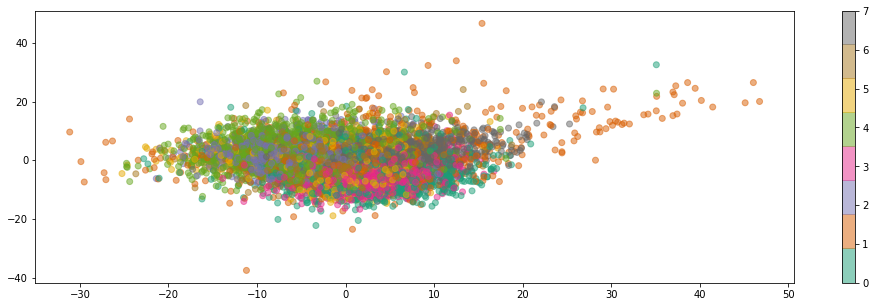

In [394]:
genre1 = tracks['track', 'genre_top'] == 'Rock'
genre2 = tracks['track', 'genre_top'] == 'Electronic'

small = tracks['set', 'subset'] <= 'small'

train = tracks['set', 'split'] == 'training'
val = tracks['set', 'split'] == 'validation'
test = tracks['set', 'split'] == 'test'


X = features.loc[small,]

X = skl.preprocessing.StandardScaler().fit_transform(X)
X = skl.decomposition.PCA(.95).fit_transform(X)

y = tracks.loc[small, ('track', 'genre_top')]
y = skl.preprocessing.LabelEncoder().fit_transform(y)

plt.scatter(X[:,0], X[:,1], c=y, cmap='Dark2', alpha=0.5)
plt.colorbar()
X.shape, y.shape

In [395]:
train = tracks['set', 'split'] == 'training'
val = tracks['set', 'split'] == 'validation'
test = tracks['set', 'split'] == 'test'

y_train = tracks.loc[small & train, ('track', 'genre_top')]
y_test = tracks.loc[small & test, ('track', 'genre_top')]
y_val = tracks.loc[small & val, ('track', 'genre_top')]
X_train = features.loc[small & train]
X_test = features.loc[small & test]
X_val = features.loc[small & val]

print(y_train)
print('{} training examples, {} testing examples'.format(y_train.size, y_test.size))
print('{} features, {} classes'.format(X_train.shape[1], np.unique(y_train).size))

track_id
2         Hip-Hop
5         Hip-Hop
10            Pop
140          Folk
141          Folk
           ...   
153955        Pop
153956        Pop
154413        Pop
154414        Pop
155066    Hip-Hop
Name: (track, genre_top), Length: 6400, dtype: category
Categories (16, object): [Blues, Classical, Country, Easy Listening, ..., Pop, Rock, Soul-RnB,
                          Spoken]
6400 training examples, 800 testing examples
518 features, 8 classes


In [396]:
# Be sure training samples are shuffled.
X_train, y_train = skl.utils.shuffle(X_train, y_train, random_state=34)

# Standardize features by removing the mean and scaling to unit variance.
scaler = skl.preprocessing.StandardScaler(copy=False)
scaler.fit_transform(X_train)
scaler.transform(X_test)

array([[ 0.1253238 ,  0.59807614, -0.10177305, ..., -0.10643952,
        -0.8105098 , -0.84468934],
       [-0.34768999, -0.35213792, -0.0645586 , ..., -0.51699423,
        -0.23005883,  1.11347606],
       [-0.0231874 , -0.03538058, -0.03524516, ..., -0.51699423,
         0.08205794,  0.54353052],
       ...,
       [-0.47744417, -0.39346363, -0.15097715, ..., -0.31171687,
         0.04967999,  2.57694115],
       [-0.52918994, -0.47181669, -0.1345473 , ..., -0.10643952,
         1.22919953,  1.71213092],
       [-0.46718922, -0.3620704 , -0.06173892, ...,  1.33050197,
        -0.01398353,  3.47595249]])

In [0]:
from sklearn.metrics import confusion_matrix
import itertools

def train_model(model):
    model.fit(X_train, y_train)
    score = model.score(X_test, y_test)
    print('Accuracy: {:.2%}'.format(score))
    
def draw_cm(model, filename):
    y_predict = model.predict(X_test)
    cm = confusion_matrix(y_test, y_predict)
    print(cm)
    
    df_cm = pd.DataFrame(cm, index = [i for i in genre_names],
                      columns = [i for i in genre_names])
    fig = plt.figure(figsize=(15,15))
    ax = fig.add_subplot(111)
    cax = ax.matshow(df_cm, cmap='hot')
    fig.colorbar(cax)
    ax.set_xticks(np.arange(8))
    ax.set_yticks(np.arange(8))
    ax.set_xticklabels(genre_names)
    ax.set_yticklabels(genre_names)
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="black" if cm[i, j] > thresh else "white")

    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.savefig(filename)
    plt.show()

Accuracy: 47.88%
[[60  9  0  9  6  3  6  7]
 [ 9 43 10  1 18  2  8  9]
 [ 0 23 25  0 11 12 16 13]
 [13  4  0 72  3  5  1  2]
 [ 2 24 26  1 38  1  5  3]
 [ 5  3 28  6  3 41 11  3]
 [14  3  9 13  6  7 41  7]
 [ 0 12  3  4  8  0 10 63]]


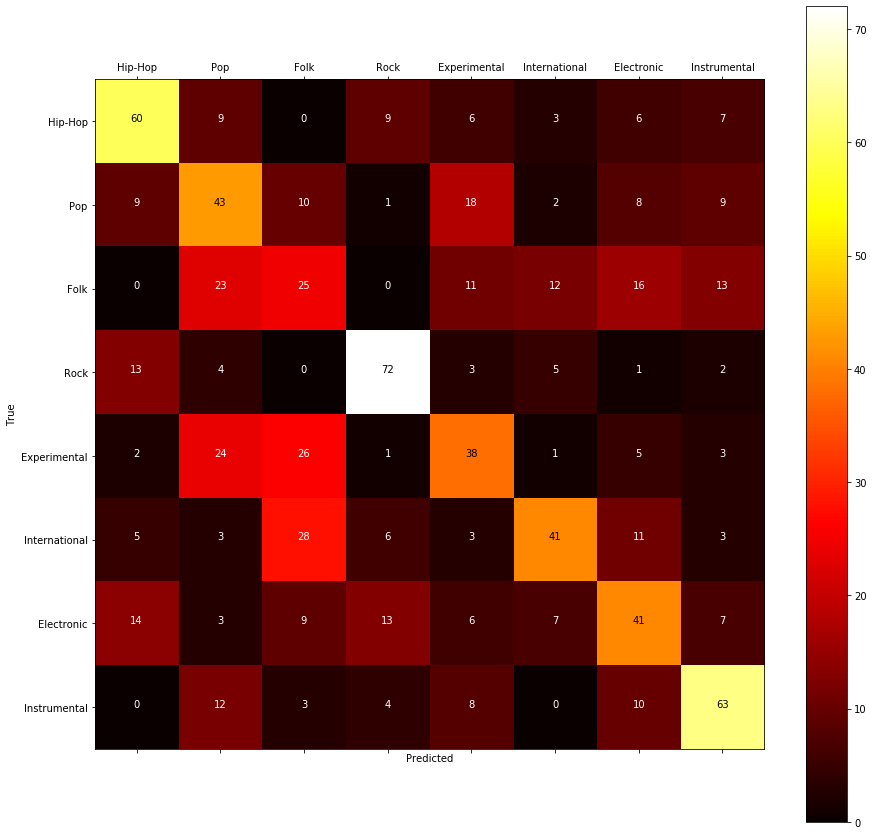

In [168]:
# Support vector classification.
svc = skl.svm.SVC()
train_model(svc)
draw_cm(svc,'baseline_scv_cm.png')

Accuracy: 40.00%
[[45 21  0  9  5  4  7  9]
 [10 32 14  2 14  8 11  9]
 [ 2 28 31  1  5 10 21  2]
 [ 9  8  2 63  0 10  1  7]
 [ 3 12 31  2 36  2 11  3]
 [ 6  6 26  4  6 37 12  3]
 [17 12  4 10  7  9 25 16]
 [ 4 15  7  2  1  5 15 51]]


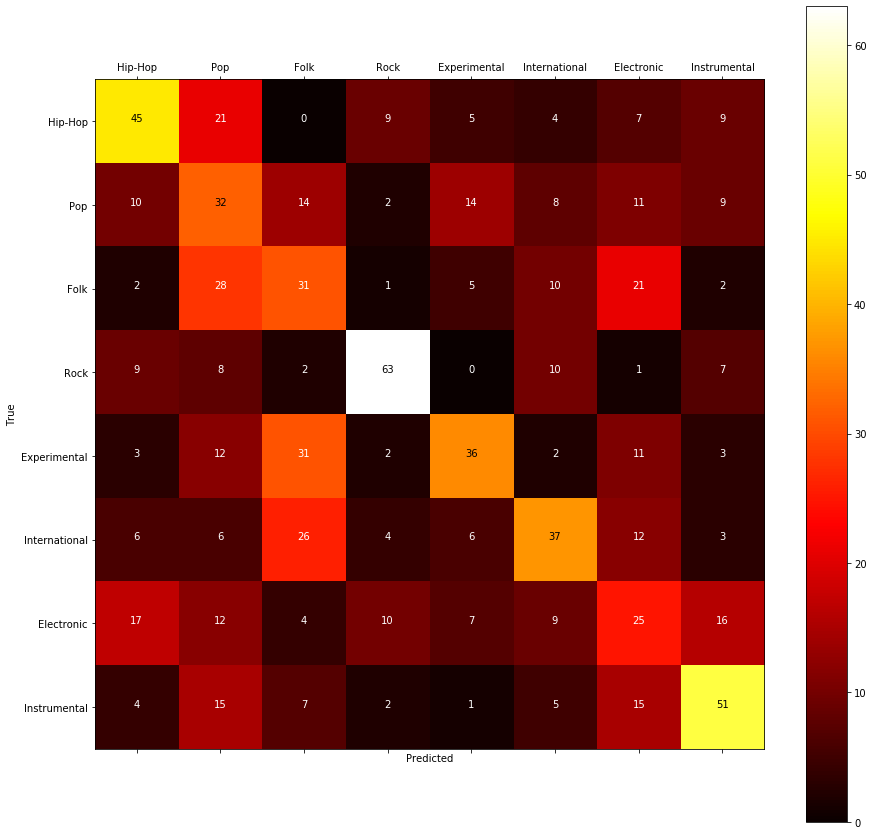

In [0]:
# Perceptron classification.
per = skl.linear_model.Perceptron(tol=1e-9, random_state=532)
train_model(per)
draw_cm(per,'baseline_perceptron_cm.png')

Accuracy: 39.62%
[[45  2  0 26  7  4 11  5]
 [16 14 21  2 15 10  7 15]
 [ 0 26 28  0 15 10  6 15]
 [15  3  1 63  2  4  0 12]
 [ 1  9 47  1 33  3  2  4]
 [ 8  4 32  9  0 31  9  7]
 [15  5  7 11 12 16 30  4]
 [ 1  7  2  1  6  2  8 73]]


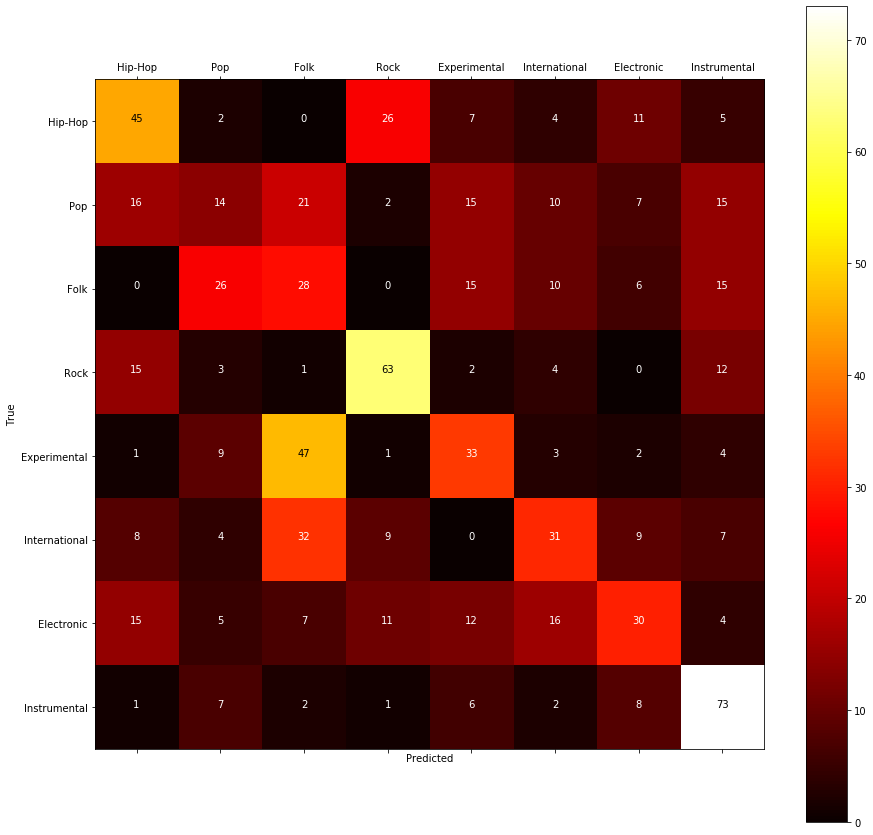

In [0]:
# Nearest centroid classification.
nei = skl.neighbors.NearestCentroid()
train_model(nei)
draw_cm(nei,'baseline_nearest_centroid_cm.png')

Accuracy: 29.25%
[[35 16  5 15  9  9  6  5]
 [ 9 22 12  9 16  7 12 13]
 [ 7 18 16  4 18 11 10 16]
 [14  7  2 38  1 17 12  9]
 [ 5 17 19  4 30  8 10  7]
 [ 9 19 11  6  2 37 10  6]
 [17  9 17  8  5 16 21  7]
 [ 5  9  7  9 15  3 17 35]]


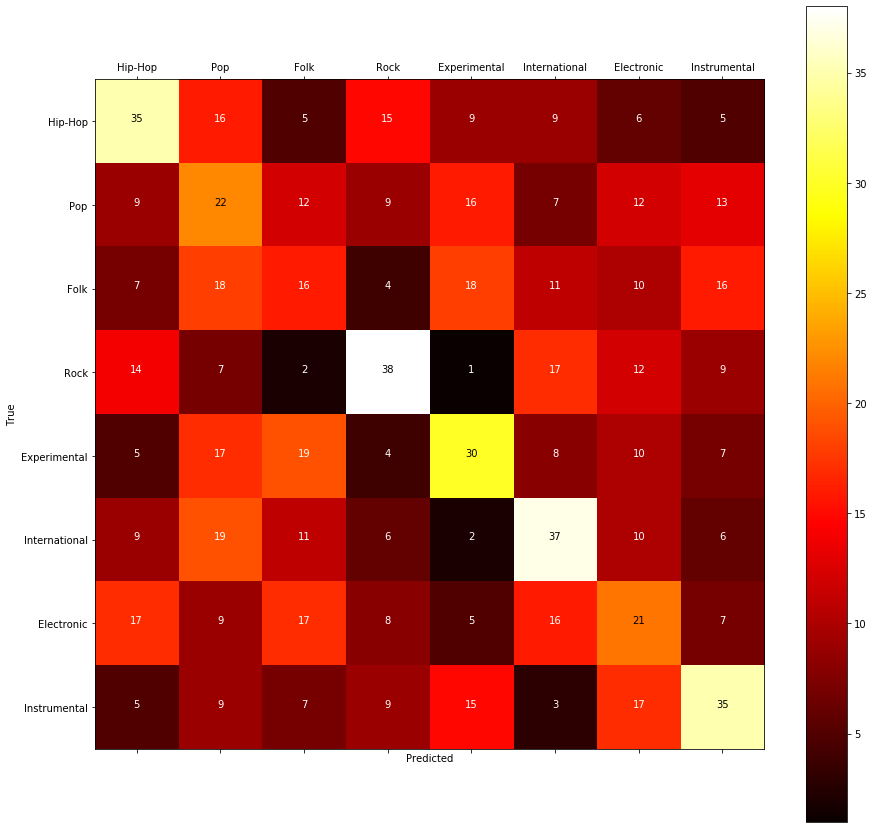

In [0]:
# Decision tree classification.
dtc = skl.tree.DecisionTreeClassifier()
train_model(dtc)
draw_cm(dtc,'baseline_decision_tree_cm.png')

Accuracy: 43.25%
[[48 10  2  8  6  3 13 10]
 [ 8 38  9  1 14  4 13 13]
 [ 0 29 28  0  5  8 19 11]
 [11  4  2 63  1  3 12  4]
 [ 4 11 21  1 45  2 14  2]
 [ 3  9 19  4  2 46 16  1]
 [13 11 15  6  9  4 35  7]
 [ 4 13  8  2  9  4 17 43]]


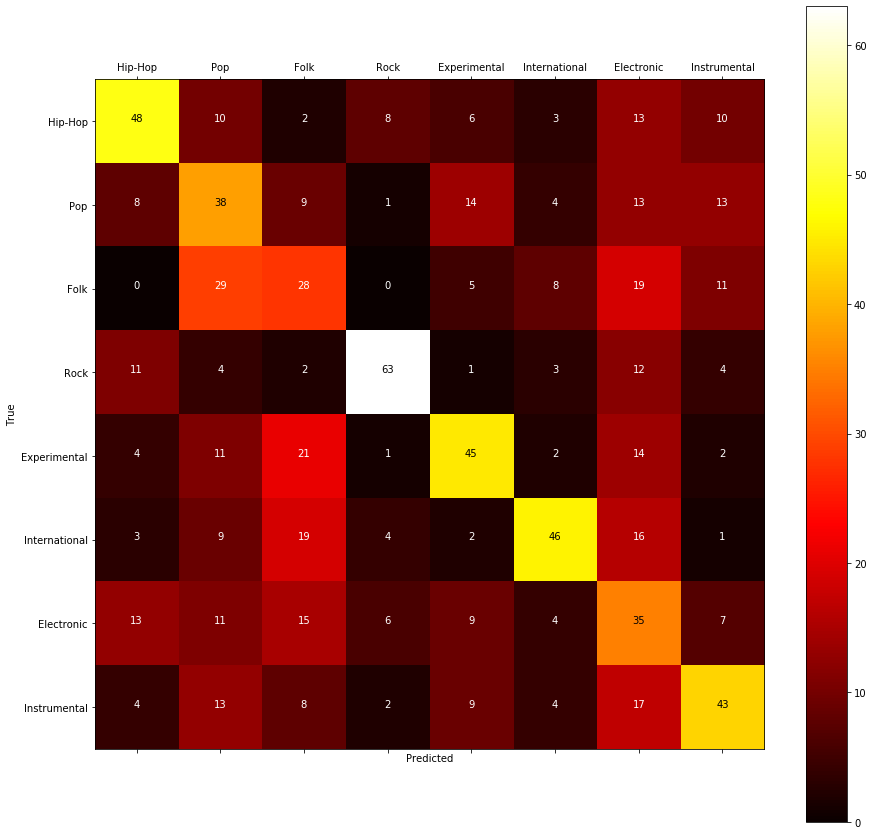

In [0]:
# NN classification.
from sklearn.neural_network import MLPClassifier                                       
mlp_1 = MLPClassifier(solver='lbfgs', alpha=1e-5, max_iter=1000,
                   hidden_layer_sizes=(256, 128, 64, 8), random_state=532)
train_model(mlp_1)
draw_cm(mlp_1,'baseline_mlp_lbfgs_cm.png')

Accuracy: 41.38%
[[53  7  0 13  8  2  9  8]
 [12 45 10  2 13  2 12  4]
 [ 4 38 13  0  9 16 12  8]
 [16  2  1 67  2  4  8  0]
 [ 6 19 23  0 35  3 10  4]
 [ 6 10 16  3  4 49 10  2]
 [19 11 10  7  6 10 32  5]
 [ 5 13 11  1  5  4 24 37]]


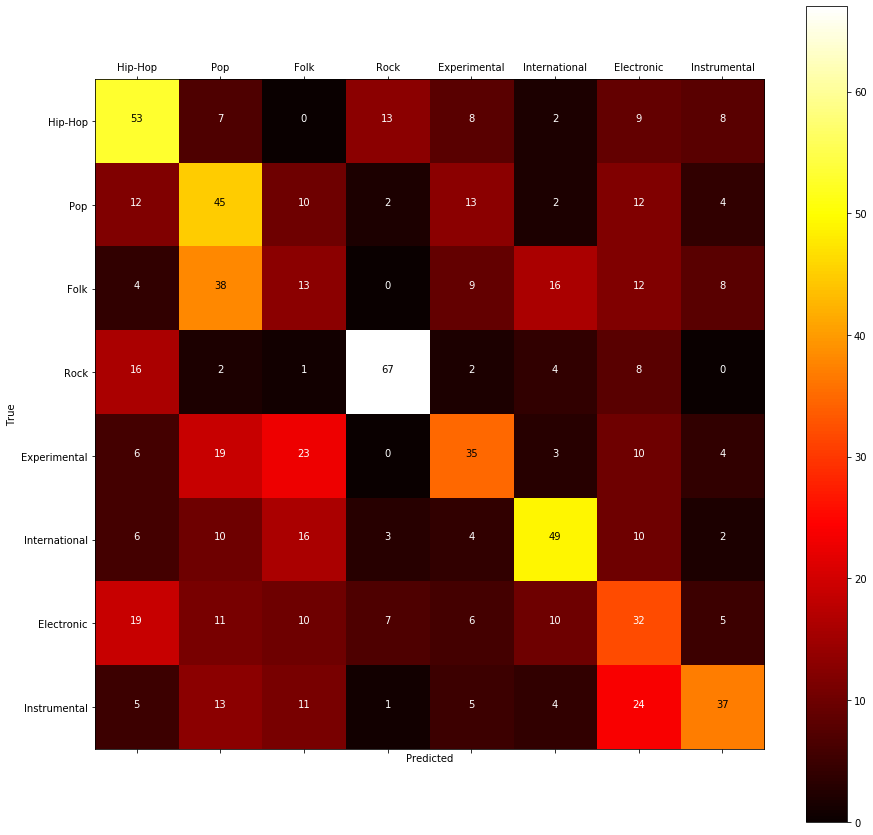

In [0]:
mlp_2 = MLPClassifier(solver='adam', alpha=1e-5, max_iter=1000, activation='relu',
                   hidden_layer_sizes=(256, 128, 64, 8), random_state=532)
train_model(mlp_2)
draw_cm(mlp_2,'baseline_mlp_adam_cm.png')

In [401]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Conv2D
from keras.utils import np_utils
from tensorflow.keras.optimizers import RMSprop, Nadam

import keras

# X_train, X_test_val, y_train, y_test_val = skl.model_selection.train_test_split(X, y, test_size=0.2)

# X_test, X_val = np.split(X_test_val, 2)
# y_test, y_val = np.split(y_test_val, 2)

## Label encode y - data
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_val = le.fit_transform(y_val)
y_test = le.fit_transform(y_test)
le.classes_

print(X_train.shape, X_test.shape, y_train.shape, y_val.shape)
print('{} training examples, {} testing examples'.format(y_train.size, y_test.size))
print('{} features, {} classes'.format(X_train.shape[1], np.unique(y_train).size))

(6400, 518) (800, 518) (6400,) (800,)
6400 training examples, 800 testing examples
518 features, 8 classes


In [402]:
model = Sequential()
model.add(Dense(128, input_dim=X_train.shape[1], activation='relu'))

model.add(Dropout(0.4))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(8, activation='softmax'))

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model.summary()


Model: "sequential_94"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_331 (Dense)            (None, 128)               66432     
_________________________________________________________________
dropout_221 (Dropout)        (None, 128)               0         
_________________________________________________________________
dense_332 (Dense)            (None, 32)                4128      
_________________________________________________________________
dropout_222 (Dropout)        (None, 32)                0         
_________________________________________________________________
dense_333 (Dense)            (None, 8)                 264       
Total params: 70,824
Trainable params: 70,824
Non-trainable params: 0
_________________________________________________________________


In [0]:
epochs = 100
batch_size = 64

Train on 6400 samples, validate on 800 samples
Epoch 1/100
6400/6400 [==============================] - 4s 646us/sample - loss: 1.9113 - acc: 0.3022 - val_loss: 358.5711 - val_acc: 0.1363
Epoch 2/100
6400/6400 [==============================] - 1s 132us/sample - loss: 1.5481 - acc: 0.4519 - val_loss: 520.8060 - val_acc: 0.1262
Epoch 3/100
6400/6400 [==============================] - 1s 127us/sample - loss: 1.4144 - acc: 0.4953 - val_loss: 641.9709 - val_acc: 0.1250
Epoch 4/100
6400/6400 [==============================] - 1s 134us/sample - loss: 1.3284 - acc: 0.5288 - val_loss: 539.6034 - val_acc: 0.1325
Epoch 5/100
6400/6400 [==============================] - 1s 138us/sample - loss: 1.2750 - acc: 0.5470 - val_loss: 681.9072 - val_acc: 0.1637
Epoch 6/100
6400/6400 [==============================] - 1s 143us/sample - loss: 1.2099 - acc: 0.5733 - val_loss: 637.5450 - val_acc: 0.1462
Epoch 7/100
6400/6400 [==============================] - 1s 139us/sample - loss: 1.1630 - acc: 0.5920 - val

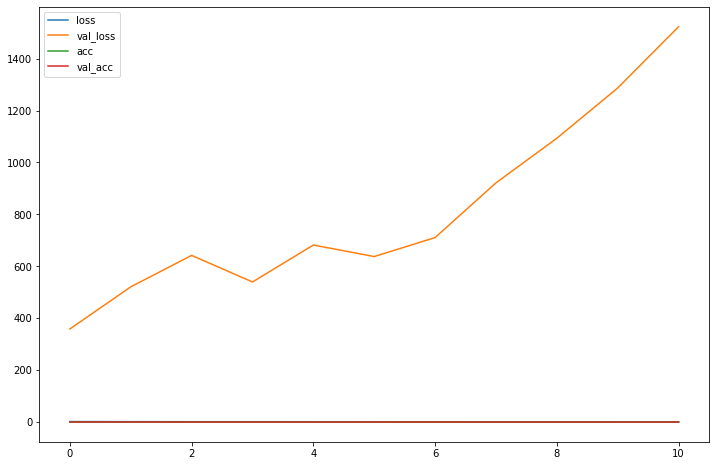

800/800 [==============================] - 0s 135us/sample - loss: 1.5873 - acc: 0.4650
Test loss: 1.5873459768295288
Test accuracy: 0.465


In [404]:
tb_hist = keras.callbacks.TensorBoard(log_dir='.', histogram_freq=0, write_graph=True, write_images=True)

es_callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
hist = model.fit(x=X_train, y=y_train, epochs=epochs, batch_size=batch_size, validation_data= (X_val, y_val), callbacks=[es_callback]) 

plt.figure(figsize=(12,8))
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.plot(hist.history['acc'])
plt.plot(hist.history['val_acc'])
plt.legend(['loss','val_loss', 'acc','val_acc'])
plt.show()

score = model.evaluate(x=X_test, y=y_test)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

In [0]:
model.save('asdf.h5')

In [408]:
model = Sequential()
model.add(Dense(128, input_dim=X_train.shape[1], activation='relu'))

model.add(Dropout(0.6))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(8, activation='softmax'))

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "sequential_96"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_337 (Dense)            (None, 128)               66432     
_________________________________________________________________
dropout_225 (Dropout)        (None, 128)               0         
_________________________________________________________________
dense_338 (Dense)            (None, 256)               33024     
_________________________________________________________________
dropout_226 (Dropout)        (None, 256)               0         
_________________________________________________________________
dense_339 (Dense)            (None, 8)                 2056      
Total params: 101,512
Trainable params: 101,512
Non-trainable params: 0
_________________________________________________________________


Train on 6400 samples, validate on 800 samples
Epoch 1/100
6400/6400 [==============================] - 1s 157us/sample - loss: 1.1236 - acc: 0.6044 - val_loss: 1140.3458 - val_acc: 0.1213
Epoch 2/100
6400/6400 [==============================] - 1s 158us/sample - loss: 1.1064 - acc: 0.6045 - val_loss: 1274.9768 - val_acc: 0.1462
Epoch 3/100
6400/6400 [==============================] - 1s 157us/sample - loss: 1.0821 - acc: 0.6147 - val_loss: 1561.0395 - val_acc: 0.1163
Epoch 4/100
6400/6400 [==============================] - 1s 163us/sample - loss: 1.0705 - acc: 0.6239 - val_loss: 1709.5327 - val_acc: 0.1238
Epoch 5/100
6400/6400 [==============================] - 1s 159us/sample - loss: 1.0417 - acc: 0.6236 - val_loss: 1619.5416 - val_acc: 0.1163
Epoch 6/100
6400/6400 [==============================] - 1s 162us/sample - loss: 1.0519 - acc: 0.6239 - val_loss: 1842.2003 - val_acc: 0.1013
Epoch 7/100
6400/6400 [==============================] - 1s 165us/sample - loss: 1.0193 - acc: 0.6395

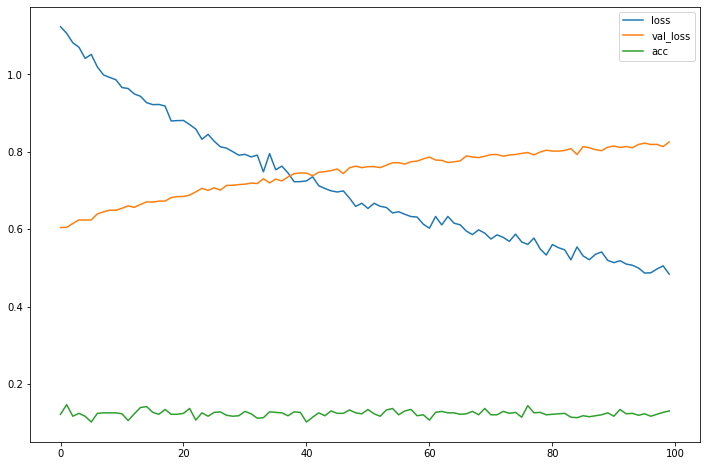

800/800 [==============================] - 0s 163us/sample - loss: 2.4740 - acc: 0.4600
Test loss: 2.4740212392807006
Test accuracy: 0.46


In [410]:
tb_hist = keras.callbacks.TensorBoard(log_dir='.', histogram_freq=0, write_graph=True, write_images=True)

es_callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
hist = model.fit(x=X_train, y=y_train, epochs=epochs, batch_size=batch_size, validation_data= (X_val, y_val)) 

plt.figure(figsize=(12,8))
plt.plot(hist.history['loss'])
plt.plot(hist.history['acc'])
plt.plot(hist.history['val_acc'])
plt.legend(['loss','val_loss', 'acc','val_acc'])
plt.show()

score = model.evaluate(x=X_test, y=y_test)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

In [0]:
model.save('DNN.h5')

In [389]:
model_arch = model.model.to_json()

AttributeError: ignored

[[53  6  0 14 10  1 10  6]
 [ 4 49 11  2 13  3 11  7]
 [ 1 39 11  0  6  8 25 10]
 [ 8  8  1 70  2  2  5  4]
 [ 3 16 18  1 45  1 10  6]
 [ 7  5 26  5  4 39 12  2]
 [17  5  6  5 10  4 46  7]
 [ 1 14  4  3  5  0 18 55]]


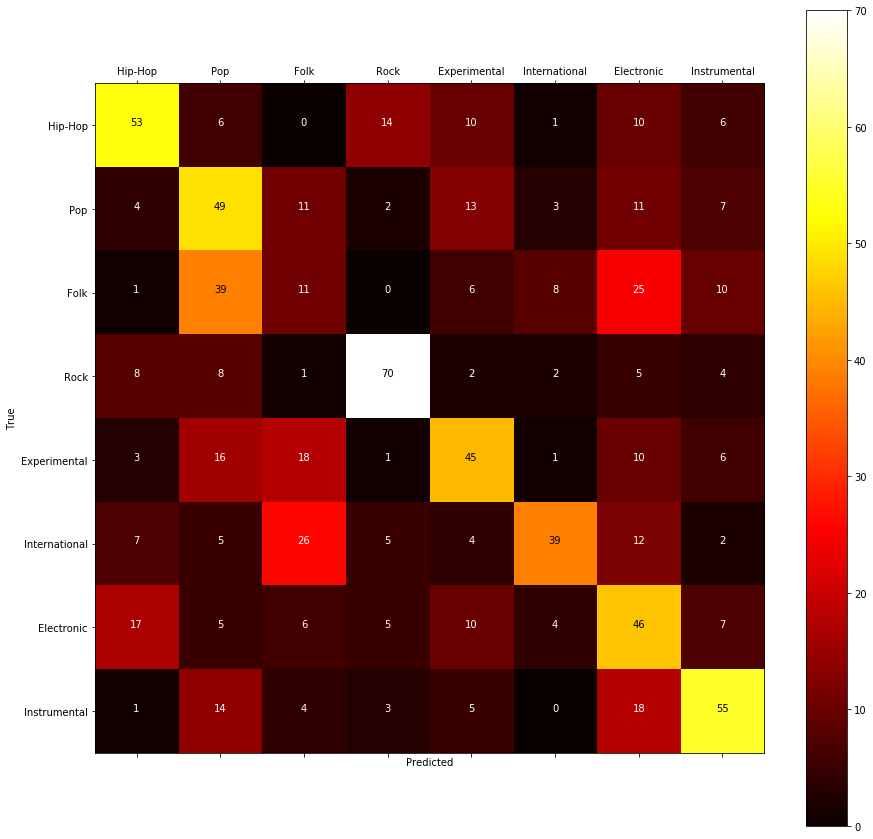

In [411]:
def draw_cm(model, filename):
    y_predict = model.predict_classes(X_test)
    cm = confusion_matrix(y_test, y_predict)
    print(cm)
    
    df_cm = pd.DataFrame(cm, index = [i for i in genre_names],
                      columns = [i for i in genre_names])
    fig = plt.figure(figsize=(15,15))
    ax = fig.add_subplot(111)
    cax = ax.matshow(df_cm, cmap='hot')
    fig.colorbar(cax)
    ax.set_xticks(np.arange(8))
    ax.set_yticks(np.arange(8))
    ax.set_xticklabels(genre_names)
    ax.set_yticklabels(genre_names)
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="black" if cm[i, j] > thresh else "white")

    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.savefig(filename)
    plt.show()

draw_cm(model, 'DNN_overfitting_cm.png')

In [388]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
! cp DNN_overfitting_cm.png /content/drive/My\ Drive/MGC/